Для инвестирования 5 млн руб. и cтавки купона, равного 20% разработайте внебиржевой опцион “Autocallable” с ежеквартальным купоном и возможностью досрочного автоматического погашения опциона каждые 3 месяца, если на ежеквартальную купонную дату текущая цена бумаги с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance) превышает или равна барьеру отзыва.

Если продукт не был отозван досрочно, и на последнюю купонную дату текущая цена worst of превышает или равна барьеру поставки, то продукт погашается с выплатой 100% номинала. Иначе, если хотя бы один базовый актив опциона оказался ниже барьера поставки, то осуществляется выплата денежных средств в сумме, равной эквиваленту «поставки бумаги», бумаги с наибольшим снижением относительно своей первоначальной стоимости, по ее первоначальной цене.

В корзину включить четыре базовых актива, первоначальную стоимость определить на день, предшествующий дате запуска (100%). Установить барьер отзыва 105%, купонный барьер 98%, барьер поставки 90% в процентах от первоначальной стоимости каждого базового актива корзину.

**Дата запуска:** 27-07-2022.

**Дата погашения:** 25-07-2023.

**Даты ежеквартальных наблюдений:** 25-10-2022, 25-01-2023, 25-04-2023.

1. Определить действия на купонные даты (выплачивается купон; выплачивается купон с досрочным погашением продукта; не выплачивается, но запоминается; выплачивается купон за текущий и предыдущие кварталы; производится погашение продукта с «эффектом поставки»).
1. Вычислить финансовый результат по состоянию на 25-04-2023,
определить бумагу с наибольшим снижением относительно своей первоначальной стоимости.
1. Привести иллюстративные графики, на которых отобразить бумагу с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance), купонные даты и действия в эти даты, уровни барьеров отзыва, поставки и купонного барьера, первоначальную стоимость актива,
провести исследование влияния уровней барьеров (барьер отзыва, купонный барьер, барьер поставки) на финансовый результат.
1. Повторить расчеты для метода оценки базовых активов -- средневзвешенная динамика стоимости всех активов (average-of perfomance).

[Примеры графиков и расчетов.](https://www.open-broker.com/files/Presentation_OTC-Option_Autocallable_.pdf)


In [ ]:
# ваш код

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [2]:
def download_data(assets, start_date, end_date):
    data = {}
    for asset in assets:
        data[asset] = yf.download(asset, start=start_date, end=end_date)['Close']
    return pd.DataFrame(data)

def calculate_worst_of(data, initial_prices, observation_dates):
    initial_prices = pd.Series(initial_prices)  
    worst_of = []
    worst_assets = []
    worst_of_prices = []
    worst_of_dates = []

    for i in range(1, len(observation_dates)):
        sub_data = data.loc[observation_dates[i-1]:observation_dates[i]]
        min_prices = sub_data.min(axis=0) 
        performance = min_prices / initial_prices  
        worst_asset = performance.idxmin()  
        worst_of.append(performance.min())  
        worst_assets.append(worst_asset)  
        worst_of_prices.append(sub_data[worst_asset].min())  
        worst_of_dates.append(sub_data[worst_asset].idxmin())  
    return worst_of, worst_assets, worst_of_prices, worst_of_dates



def calculate_payout(investment, worst_of, quarterly_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates):
    coupons = []
    total_payout = 0
    redeemed = False
    actions = []
    
    for i, wo in enumerate(worst_of):
        if wo >= call_barrier:
            total_payout = investment + investment * quarterly_coupon_rate * (i + 1)
            coupons.append(quarterly_coupon_rate * (i + 1))
            actions.append(f"Досрочное погашение ({observation_dates[i]})")
            redeemed = True
            break
        elif wo >= coupon_barrier:
            coupons.append(quarterly_coupon_rate)
            actions.append(f"Выплата купона ({observation_dates[i]})")
        else:
            coupons.append(0)
            actions.append(f"Купон не выплачен ({observation_dates[i]})")

    if not redeemed:
        if worst_of[-1] >= delivery_barrier:
            total_payout = investment + investment * sum(coupons)
            actions.append(f"Погашение с выплатой номинала ({observation_dates[-1]})")
        else:
            total_payout = investment * worst_of[-1]
            actions.append(f"Погашение с эффектом поставки ({observation_dates[-1]})")

    return total_payout, coupons, actions

def calculate_payout_average(investment, average_of, quarterly_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates):
    """Расчёт выплат и действий для average-of performance."""
    coupons = []
    total_payout = 0
    redeemed = False
    actions = []

    for i, ao in enumerate(average_of):
        if ao >= call_barrier:
            total_payout = investment + investment * quarterly_coupon_rate * (i + 1)
            coupons.append(quarterly_coupon_rate * (i + 1))
            actions.append(f"Досрочное погашение ({observation_dates[i]})")
            redeemed = True
            break
        elif ao >= coupon_barrier:
            coupons.append(quarterly_coupon_rate)
            actions.append(f"Выплата купона ({observation_dates[i]})")
        else:
            coupons.append(0)
            actions.append(f"Купон не выплачен ({observation_dates[i]})")

    if not redeemed:
        if average_of[-1] >= delivery_barrier:
            total_payout = investment + investment * sum(coupons)
            actions.append(f"Погашение с выплатой номинала ({observation_dates[-1]})")
        else:
            total_payout = investment * average_of[-1]
            actions.append(f"Погашение с эффектом поставки ({observation_dates[-1]})")

    return total_payout, coupons, actions

def plot_results(data, initial_prices, worst_of_prices, worst_assets, worst_of_dates, observation_dates, call_barrier, coupon_barrier, delivery_barrier):
    plt.figure(figsize=(16, 8))
    
    for asset in data.columns:
        plt.plot(data.index, data[asset] / initial_prices[asset] * 100, label=asset)

    for obs_date in observation_dates:
        plt.axvline(pd.to_datetime(obs_date), color='gray', linestyle='--', alpha=0.7, label='Observation Date' if obs_date == observation_dates[0] else "")

    worst_of_percentages = [
        (price / initial_prices[asset]) * 100 for price, asset in zip(worst_of_prices, worst_assets)
    ]
    plt.scatter(worst_of_dates, worst_of_percentages, color='black', label='Worst-of', zorder=5)
    
    for date, percentage, asset in zip(worst_of_dates, worst_of_percentages, worst_assets):
        plt.text(date, percentage, asset, fontsize=9, ha='right', va='bottom')

    plt.axhline(call_barrier * 100, color='green', linestyle='--', label='Барьер отзыва (105%)')
    plt.axhline(coupon_barrier * 100, color='blue', linestyle='--', label='Купонный барьер (98%)')
    plt.axhline(delivery_barrier * 100, color='red', linestyle='--', label='Барьер поставки (90%)')

    # Настройки графика
    plt.title('Динамика активов, барьеры и worst-of')
    plt.xlabel('Дата')
    plt.ylabel('Цена (% от начальной)')
    plt.legend()
    plt.show()

In [7]:
investment = 5000000
annual_coupon_rate = 0.2
quarterly_coupon_rate = annual_coupon_rate / 4
call_barrier = 1.05
coupon_barrier = 0.98
delivery_barrier = 0.90
observation_dates = ['2022-07-27', '2022-10-25', '2023-01-25', '2023-04-25', '2023-07-25']

# assets = ['AAPL', 'MSFT', 'GOOGL', 'AMZN','BABA', 'TSLA']
assets = ['AAPL', 'MSFT', 'GOOGL', 'AMZN',  'NFLX', 'NVDA', 'DIS', 'V', 'JPM', 'PYPL', 'PFE', 'INTC', 'T', 'VZ', 'CSCO', 'CMCSA', 'XOM', 'NKE', 'KO', 'ABT', 'MRK', 'ORCL']

data = download_data(assets, '2022-07-26', '2023-07-26')
data.head()

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

,AAPL,MSFT,GOOGL,AMZN,NFLX,NVDA,DIS,V,JPM,PYPL,...,T,VZ,CSCO,CMCSA,XOM,NKE,KO,ABT,MRK,ORCL
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-26,151.600006,251.899994,105.019997,114.809998,213.910004,16.533001,99.779999,212.490005,113.419998,77.040001,...,18.299999,44.919998,43.830002,42.720001,89.629997,105.199997,63.209999,109.089996,91.290001,74.029999
2022-07-27,156.789993,268.739990,113.059998,120.970001,226.750000,17.790001,103.500000,210.470001,115.239998,86.419998,...,18.389999,44.910000,44.639999,43.369999,91.570000,107.860001,63.009998,109.989998,91.230003,75.870003
2022-07-28,157.350006,276.410004,114.220001,122.279999,226.020004,17.983999,104.900002,211.350006,114.809998,85.860001,...,18.580000,45.549999,45.619999,39.410000,92.639999,112.230003,64.059998,110.360001,89.940002,77.040001
2022-07-29,162.509995,280.739990,116.320000,134.949997,224.899994,18.163000,106.099998,212.110001,115.360001,86.529999,...,18.780001,46.189999,45.369999,37.520000,96.930000,114.919998,64.169998,108.839996,89.339996,77.839996
2022-08-01,161.509995,278.010010,114.860001,135.389999,226.210007,18.441000,106.220001,211.360001,114.209999,88.565002,...,18.730000,46.259998,45.279999,37.509998,94.480003,114.300003,64.519997,109.519997,88.529999,77.440002


[25.040000915527344, 25.540000915527344, 24.899999618530273, 35.529998779296875]
['2022-07-27', '2022-10-25', '2023-01-25', '2023-04-25', '2023-07-25']
Действия по купонным датам:
Купон не выплачен (2022-07-27)
Купон не выплачен (2022-10-25)
Купон не выплачен (2023-01-25)
Купон не выплачен (2023-04-25)
Погашение с эффектом поставки (2023-07-25)
Итоговая выплата: 3396749.45 руб.


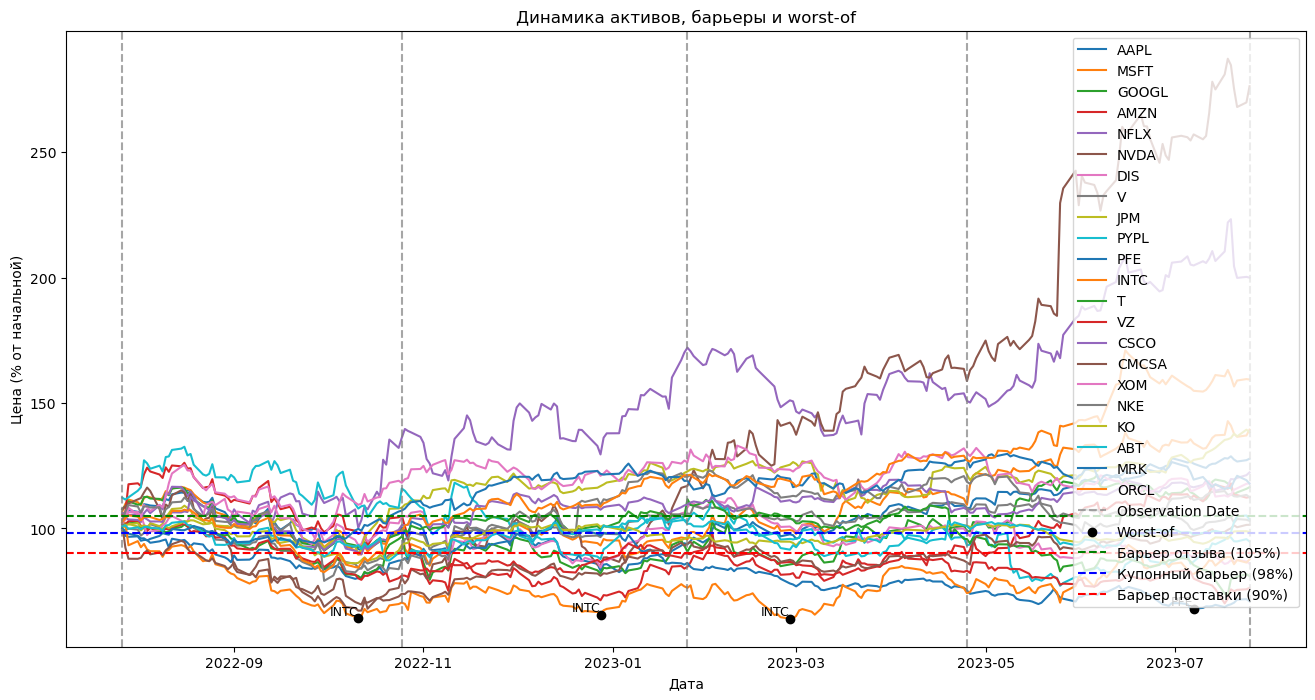

In [8]:
initial_prices = data.iloc[0].to_dict()
data = data.iloc[1:]

worst_of, worst_assets, worst_of_prices, worst_of_dates = calculate_worst_of(data, initial_prices, observation_dates)
print(worst_of_prices)
print(observation_dates)

total_payout, coupons, actions = calculate_payout(
    investment, worst_of, quarterly_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates
)

print("Действия по купонным датам:")
for action in actions:
    print(action)
print(f"Итоговая выплата: {total_payout:.2f} руб.")

plot_results(data, initial_prices, worst_of_prices, worst_assets, worst_of_dates, observation_dates, call_barrier, coupon_barrier, delivery_barrier)

In [9]:
def calculate_average_of(data, initial_prices, observation_dates): # средняя производительность всех активов
    """Расчёт average-of для заданных купонных дат."""
    initial_prices = pd.Series(initial_prices)  
    average_of = []

    for i in range(1, len(observation_dates)):
        sub_data = data.loc[observation_dates[i-1]:observation_dates[i]]
        mean_performance = sub_data.mean(axis=0) / initial_prices
        average_of.append(mean_performance.mean())  

    return average_of

def calculate_payout_average(investment, average_of, quarterly_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates):
    """Расчёт выплат и действий для average-of performance."""
    coupons = []
    total_payout = 0
    redeemed = False
    actions = []

    for i, ao in enumerate(average_of):
        if ao >= call_barrier:
            total_payout = investment + investment * quarterly_coupon_rate * (i + 1)
            coupons.append(quarterly_coupon_rate * (i + 1))
            actions.append(f"Досрочное погашение ({observation_dates[i]})")
            redeemed = True
            break
        elif ao >= coupon_barrier:
            coupons.append(quarterly_coupon_rate)
            actions.append(f"Выплата купона ({observation_dates[i]})")
        else:
            coupons.append(0)
            actions.append(f"Купон не выплачен ({observation_dates[i]})")

    if not redeemed:
        if average_of[-1] >= delivery_barrier:
            total_payout = investment + investment * sum(coupons)
            actions.append(f"Погашение с выплатой номинала ({observation_dates[-1]})")
        else:
            total_payout = investment * average_of[-1]
            actions.append(f"Погашение с эффектом поставки ({observation_dates[-1]})")

    return total_payout, coupons, actions


def plot_performance_graph(observation_dates, average_of, call_barrier, coupon_barrier, delivery_barrier):

    average_of_points = [ao * 100 for ao in average_of]

    plt.figure(figsize=(12, 6))
    plt.plot(observation_dates[1:], average_of_points, color='orange', label='Average-of', linestyle='-', marker='o')

    plt.xlabel('Даты наблюдений')
    plt.ylabel('Средняя производительность (%)')
    plt.title('График средней производительности активов')

    for i, value in enumerate(average_of_points):
        plt.text(observation_dates[i + 1], value, f'{value:.2f}', fontsize=9, ha='center', va='bottom')

    plt.axhline(y=call_barrier * 100, color='red', linestyle='--', label='Call Barrier')
    plt.axhline(y=coupon_barrier * 100, color='blue', linestyle='--', label='Coupon Barrier')
    plt.axhline(y=delivery_barrier * 100, color='green', linestyle='--', label='Delivery Barrier')

    plt.legend()

    for date in observation_dates[1:]:
        plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)

    plt.grid()
    plt.tight_layout()
    plt.show()


Действия по купонным датам для average-of performance:
Выплата купона (2022-07-27)
Выплата купона (2022-10-25)
Досрочное погашение (2023-01-25)
Итоговая выплата (average-of): 5750000.00 руб.


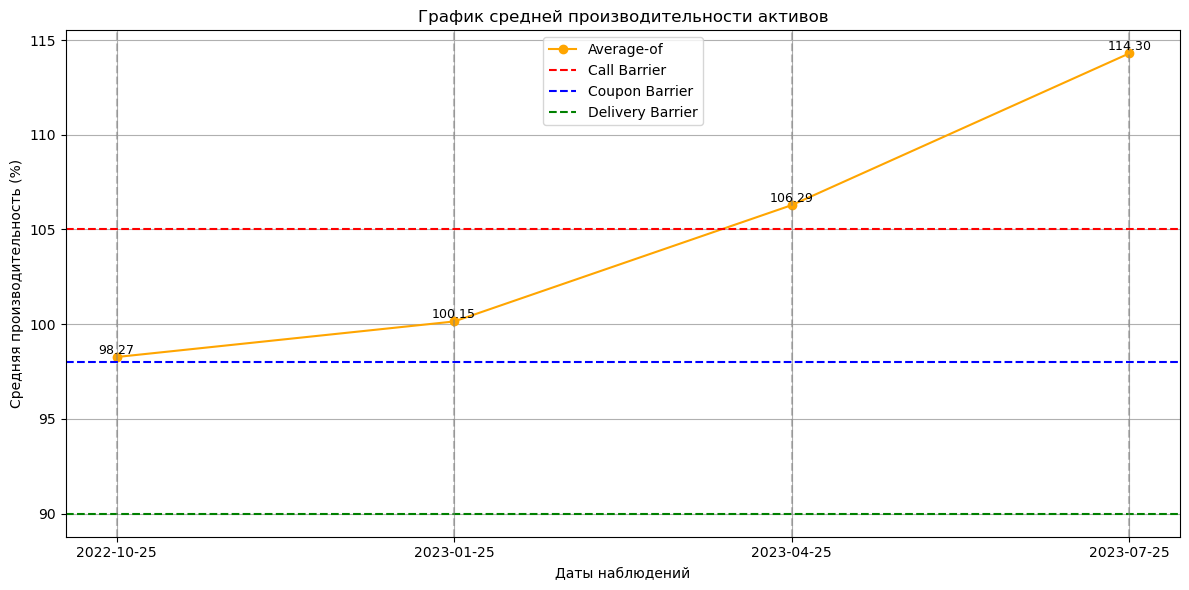

In [5]:
average_of = calculate_average_of(data, initial_prices, observation_dates)

total_payout_avg, coupons_avg, actions_avg = calculate_payout_average(
    investment, average_of, quarterly_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates
)

print("\nДействия по купонным датам для average-of performance:")
for action in actions_avg:
    print(action)
print(f"Итоговая выплата (average-of): {total_payout_avg:.2f} руб.")


plot_performance_graph(observation_dates, average_of, call_barrier, coupon_barrier, delivery_barrier)